<a href="https://colab.research.google.com/github/maitysuvo19/News-Articles-Classification/blob/main/Real_news_rnn_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
!unzip news.zip -d news

Archive:  news.zip
   creating: news/news article/News Articles/
   creating: news/news article/News Articles/business/
  inflating: news/news article/News Articles/business/001.txt  
  inflating: news/news article/News Articles/business/002.txt  
  inflating: news/news article/News Articles/business/003.txt  
  inflating: news/news article/News Articles/business/004.txt  
  inflating: news/news article/News Articles/business/005.txt  
  inflating: news/news article/News Articles/business/006.txt  
  inflating: news/news article/News Articles/business/007.txt  
  inflating: news/news article/News Articles/business/008.txt  
  inflating: news/news article/News Articles/business/009.txt  
  inflating: news/news article/News Articles/business/010.txt  
  inflating: news/news article/News Articles/business/011.txt  
  inflating: news/news article/News Articles/business/012.txt  
  inflating: news/news article/News Articles/business/013.txt  
  inflating: news/news article/News Articles/bus

In [ ]:
# Step 1 - Get the file details
directory = []
file = []
title = []
text = []
label = []
datapath = '/content/news/news article' 
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        #print(filename)
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

#    

In [ ]:
fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['title','text','label'], axis=1)

print("FullDf : ", fulldf.shape)
print("DF : ", df.shape)

FullDf :  (2225, 5)
DF :  (2225, 3)


In [ ]:
df['label'] =df.label.map({'sport':0, 'business':1,'politics':2,'tech':3,'entertainment':4})
df = df[["text","label"]]
df.head()

,text,label
0,IBM is spending $100m (£52m) over the next t...,3
1,Musicians are embracing the internet as a wa...,3
2,The once-famous Commodore computer brand cou...,3
3,"Web logs or blogs are everywhere, with at le...",3
4,UK gamers are getting a chance to take part ...,3


In [ ]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(df, test_size=0.2)
print("Train DF: ",train.shape)
print("Test DF: ",test.shape)

Train DF:  (1780, 2)
Test DF:  (445, 2)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import re

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant

MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 1000 # Max number of words kept at the end of each text

In [ ]:
train.columns

Index(['text', 'label'], dtype='object')

In [ ]:
train_texts = train['text'].values
train_labels = train['label'].values
test_texts = test['text'].values
test_labels = test['label'].values

labels_index ={'sport':0, 'business':1,'politics':2,'tech':3,'entertainment':4}

In [ ]:
test.columns

Index(['text', 'label'], dtype='object')

In [ ]:
test_labels

array([0, 2, 0, 4, 0, 4, 1, 0, 3, 2, 2, 2, 1, 0, 4, 0, 1, 1, 3, 3, 0, 1,
       3, 2, 4, 4, 3, 0, 3, 0, 3, 4, 2, 0, 1, 0, 0, 2, 4, 2, 1, 0, 1, 1,
       1, 3, 3, 1, 4, 3, 2, 3, 1, 1, 3, 2, 0, 0, 0, 1, 3, 2, 3, 2, 4, 2,
       0, 4, 0, 3, 0, 0, 2, 2, 0, 4, 1, 0, 3, 1, 1, 1, 0, 4, 2, 0, 1, 2,
       0, 1, 3, 2, 2, 1, 4, 2, 0, 0, 0, 2, 0, 3, 2, 4, 2, 2, 2, 1, 0, 0,
       2, 2, 0, 4, 1, 1, 4, 3, 3, 4, 2, 1, 1, 2, 0, 2, 1, 4, 1, 2, 1, 1,
       4, 3, 2, 0, 2, 0, 3, 1, 1, 0, 3, 1, 1, 1, 1, 3, 3, 1, 0, 0, 2, 1,
       2, 3, 1, 3, 1, 0, 3, 0, 4, 3, 3, 3, 4, 0, 2, 4, 1, 2, 4, 2, 3, 0,
       1, 0, 0, 0, 2, 1, 0, 4, 0, 4, 0, 0, 1, 4, 0, 1, 2, 0, 2, 3, 0, 0,
       3, 1, 0, 4, 3, 2, 4, 4, 1, 2, 0, 1, 1, 0, 4, 3, 4, 2, 4, 2, 2, 4,
       0, 2, 2, 0, 2, 3, 1, 4, 0, 2, 3, 3, 1, 2, 3, 2, 0, 0, 1, 4, 4, 3,
       0, 0, 4, 4, 0, 4, 2, 4, 0, 0, 2, 0, 3, 2, 0, 2, 4, 2, 4, 3, 0, 3,
       0, 3, 1, 3, 0, 4, 4, 2, 4, 2, 2, 4, 1, 0, 2, 1, 1, 0, 4, 0, 4, 2,
       4, 1, 3, 3, 3, 3, 4, 0, 0, 2, 2, 1, 1, 3, 3,

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator


class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)


class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 64
max_features = vocab_size + 1

#Training an LSTM with embedding on the fly
def create_model(max_features):
    """ Model creation function: returns a compiled LSTM"""


    rnnmodel = Sequential()
    rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
    rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    rnnmodel.add(Dense(5, activation='softmax'))
    rnnmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return rnnmodel


# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=5, batch_size=32, 
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(train_texts, train_labels);

Epoch 1/5
56/56 [==============================] - 153s 3s/step - loss: 1.5833 - accuracy: 0.2886
Epoch 2/5
56/56 [==============================] - 151s 3s/step - loss: 1.1928 - accuracy: 0.5096
Epoch 3/5
56/56 [==============================] - 150s 3s/step - loss: 0.7841 - accuracy: 0.7303
Epoch 4/5
56/56 [==============================] - 150s 3s/step - loss: 0.3346 - accuracy: 0.9175
Epoch 5/5
56/56 [==============================] - 151s 3s/step - loss: 0.0665 - accuracy: 0.9849


In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 13.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=1e879de5a2fe1699c76a996a4c4583aa8ebc5ef8f13f6bc10eecf1d283349428
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

Sample 35: last 1000 words (only part used by the model)
--------------------------------------------------
Headingley Friday, 25 February 2000 GMT The Tykes have brought in Newcastle prop Ed Kalman and Tom McGee from the Borders on loan while fly-half Craig McMullen has joined from Narbonne. Raphael Ibanez is named at hooker for Saracens in one of four changes. Simon Raiwalui and Ben Russell are also selected in the pack while Kevin Sorrell comes in at outside centre. - Friday's game at Headingley got the go-ahead on Friday after passing an early pitch inspection. Leeds: Balshaw; Rees, Christophers, Bell, Doherty; McMullen, Dickens; McGee, Rawlinson, Gerber; Murphy, Palmer (capt), Morgan, Parks, Popham. Replacements: Kalman, Regan, Hyde, Rigney, McMillan, Rock, Vickerman. Saracens: Bartholomeusz; Castaignede, Sorrell, Harris, Vaikona; Jackson, Bracken; Yates, Ibanez, Visagie; Raiwalui, Fullarton; Randell, Russell, Vyvyan (capt). Replacements: Cairns, Lloyd, Broster, Chesney, Johnston,

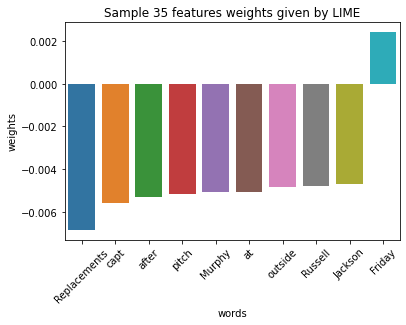

In [ ]:
# We choose a sample from test set
idx = 35
text_sample = test_texts[idx]
class_names = ['sport', 'business','politics','tech','entertainment']

print('Sample {}: last 1000 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-1000:]))
print('-'*50)
#print('Probability(sport) =', pipeline.predict_proba([text_sample]))
x=pipeline.predict_proba([text_sample]).tolist()
print('Probability(sport) =',x[0][0])
print('Probability(business) =',x[0][1])
print('Probability(politics) =',x[0][2])
print('Probability(tech) =',x[0][3])
print('Probability(entertainment) =',x[0][4])
#print('Probability(politics) =', pipeline.predict_proba([text_sample])[0,0,1,0,0])
#print('Probability(tech) =', pipeline.predict_proba([text_sample])[0,0,0,1,0])
#print('Probability(entertainment) =', pipeline.predict_proba([text_sample])[0,0,0,0,1])
print('True class: %s' % class_names[test_labels[idx]])



import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));